In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from sklearn.preprocessing import StandardScaler # data normalization
from sklearn.model_selection import train_test_split # data split
from sklearn.neighbors import KNeighborsClassifier # KNN algorithm
from sklearn.metrics import confusion_matrix # evaluation metric
from sklearn.metrics import accuracy_score # evaluation metric
from sklearn.metrics import f1_score # evaluation metric

# Table of Contents (with hyperlinks)

* [Data Cleaning](#A)
* [Feature Engineering](#B)
* [Exploratory Data Analysis](#C)
  1. [High level analysis](#C.1)
  2. [Categorization into small, medium and large business](#C.2)
  
* [Check if subscribers are current customers](#D)
* [Modelling](#E)
* [Q1. Whether the vendor offering is worth discussing with your boss](#F)
* [Q2. why or why not?](#G)

In [3]:
df_sub = pd.read_csv("subscriber_data_sample.csv")

In [4]:
df_sub

,email_address,industry,relationship_length,site_visits
0,POYZ@yahoo.com,garden,2,86
1,VGID.VGID@yahoo.com,landscape engineer,30,2019
2,KTCGW@homeandgardenXYT.com,home and garden,30,225
3,YOQUFSG.YOQUFSG@EVTlandscapearchitect.biz,landscape architect,4,80
4,SOSNEJAL.SOSNEJAL@DXKDhg.net,NaN,4,20
...,...,...,...,...
674,HSIEGEET.HSIEGEET@IHBhg.co,hg,2,13
675,UHOJRMQQ.UHOJRMQQ@HRKMgrower.biz,grower,1,11
676,NOSKIDHL2@growerXOZ.co,grower,11,154
677,outdoorLMAJVIIP@yahoo.com,outdoor,30,303


In [5]:
df1 = df_sub.copy()

In [6]:
df_sub.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 679 entries, 0 to 678
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   email_address        679 non-null    object
 1   industry             576 non-null    object
 2   relationship_length  679 non-null    int64 
 3   site_visits          679 non-null    int64 
dtypes: int64(2), object(2)
memory usage: 21.3+ KB


Let's peek into the DataFrame

Here's what the data for subscribers mean

- email_address: email addresses of the subscribers
- industry: industry of work
- relationship_length: length of relationship with magazine (years) 
- site_visits: total number of site visits to the magazine’s website

In [7]:
df_cust = pd.read_csv("pp_cust_data.csv")

In [8]:
df_cust

,email_address,active_send,active_receive
0,UQZXVWHPAR@GSLJXDZV.com,1,0
1,RLKSLDNYTDW@SIDPRQ.com,1,0
2,ONVGUCDMEACP@HMXNGE.com,1,1
3,DSMIX686@gmail.com,1,0
4,QHVKQNOGRG@DHQWP.com,1,1
...,...,...,...
2167,CSKFFNETAWXJ@KLBSHP.com,1,0
2168,SNRGZVUMFO@YEOEU.com,0,1
2169,EIZMLZKVSAZC@DFBBYZCD.com,1,1
2170,NTKYGGZIHUWA@XEOKAK.com,1,0


Here's what the data for customers mean

- email_address:  email addresses of users and 
- active_send(1:active, 0:non-active): account send active status 
- active_receive(1:active, 0:non-active): account receive active status 
(active = has transaction within last year)

## Problem statement 
(Questions to be answered)
Your objective is to perform a first-pass exploratory data analysis (3 hours or less) and
evaluate 
- whether the vendor offering is worth discussing with your boss and 
- why or why not.

##Possible Solution: 

### Q1. Whether the vendor offering is worth discussing with your boss
- Out of 30, 000 accounts, if a lead can be generated from 1000 accounts then its meaningful which is 3% of the total accounts. So assuming the data is not skewed, If I can establish that 3% of 679 accounts = ~23 accounts are useful than this vendor offering is worth discussing with the boss.

1) High level analyze the subscriber data to categorize them as individual casual sellers and large/small businesses on the basis of email id, industry. 

- After this analysis we want to remove non valuable leads -casual sellers or customers who use company to shop online or transfer money to friends and family generate $0-$200 of revenue annually.

- Eyeballing at the data gives an idea that subscribers are in the following categories:
    * businesses, 
    * professionals like architects, gardeners, 
    * businesses who have not purchased a domain name, 
    * individual users/ casual sellers.

2) Categorize 1 further to see which category they lie into. 
- large independent online sellers who do not offer: $70k-$200k
- medium businesses with online or invoice sales: $10k-$40k
- small businesses on channel partners (in particular, Shopify, Magento, and BigCommerce): $1k-$5k

3) Then for each category check there relationship length and site_visits to the magazine to check how active are they. More active users on the magazine page are likely to have more business opportunity. 

- Feature engineering: percantage of times total_site_visits / relationship_length(years) will give us an idea of how active they have been. (site_visits/ (relationship_length * 365)) *100

4) As a last step check if these business are existing customers as well and see there active status in the last year. 

# Data Cleaning <a id="A"></a>

### Tasks:
1. check for nulls
  - there are 103 null values in industry column.
2. replaced null values in industry by industry_name if industry_name in email address.
  - reduced the number of null values to 23.
  - replaced the null values with unknown industry.
3. merged similar/duplicate industry groups
  - reduced the number of industry groups from 20 to 14 by merging similar/ duplicate industry. 

In [9]:
df_sub.isnull().sum()

email_address            0
industry               103
relationship_length      0
site_visits              0
dtype: int64

In [10]:
df_sub['industry'].unique()

array(['garden', 'landscape engineer', 'home and garden',
       'landscape architect', nan, 'supply', 'architect', 'orchard',
       'designer', 'landscaping', 'gardening', 'grower', 'plants',
       'vineyard', 'outdoor', 'landscape designer', 'nursery',
       'landscaper', 'outdoor living', 'hg'], dtype=object)

In [11]:
# replaced null values in industry with the industry_name if industry_name in email address.
industry = list(df_sub['industry'].unique())
industry = [x for x in industry if pd.isnull(x) == False]
for x in industry:
    y = "".join(x.split())
    df_sub.loc[df_sub['email_address'].str.contains(y), 'industry1'] = x
    
df_sub['industry'] = df_sub['industry'].fillna(df_sub['industry1'])
len(df_sub[df_sub['industry'].isnull()])

23

Reduced the number of null values in industry from 103 to 23. Filled the null values with unknown.

In [12]:
df_sub

,email_address,industry,relationship_length,site_visits,industry1
0,POYZ@yahoo.com,garden,2,86,NaN
1,VGID.VGID@yahoo.com,landscape engineer,30,2019,NaN
2,KTCGW@homeandgardenXYT.com,home and garden,30,225,home and garden
3,YOQUFSG.YOQUFSG@EVTlandscapearchitect.biz,landscape architect,4,80,architect
4,SOSNEJAL.SOSNEJAL@DXKDhg.net,hg,4,20,hg
...,...,...,...,...,...
674,HSIEGEET.HSIEGEET@IHBhg.co,hg,2,13,hg
675,UHOJRMQQ.UHOJRMQQ@HRKMgrower.biz,grower,1,11,grower
676,NOSKIDHL2@growerXOZ.co,grower,11,154,grower
677,outdoorLMAJVIIP@yahoo.com,outdoor,30,303,outdoor


In [13]:
#Number of subscribers from each industry.
df_sub.drop('industry1', inplace= True, axis=1)
df_sub['industry'].fillna('unknown', inplace = True)
df_sub.groupby('industry').size()

industry
architect              32
designer               34
garden                 35
gardening              32
grower                 32
hg                     33
home and garden        49
landscape architect    29
landscape designer     33
landscape engineer     45
landscaper             19
landscaping            19
nursery                49
orchard                25
outdoor                51
outdoor living         44
plants                 26
supply                 43
unknown                23
vineyard               26
dtype: int64

In [14]:
def replace_col(df,to_replace,tobe_replaced):
    """
    Function to merge some entires in the industry column of df_sub df
    ----
    df = dataframe
    to_replace = final string to merge other strings
    tobe_replaced = strings to change to to_replace string
    """
    df['industry'] = [to_replace if each in tobe_replaced else each for each in df['industry']]
    return

In [15]:
#Merging similar/duplicate industry groups 
replace_col(df_sub,'landscap',['landscape architect','landscape designer', 'landscape engineer', 
                               'landscaper', 'landscaping'])
replace_col(df_sub,'outdoor',['outdoor living'])
replace_col(df_sub,'garden',['gardening'])

In [16]:
df_sub['industry'].nunique()

14

Reduced the number of industry groups from 20 to 14 by merging similar/ duplicate industry.

# Feature Engineering <a id="B"></a>

### Tasks
1. avg activity(per year) = no of times total_site_visits / relationship_length(years) will give us an idea of how active they have been. (site_visits/ (relationship_length))

2. activity_score: Lets give 50% weightage to relationship_length and 50% weightage to avg activity(per year). 
    - activity_score = 0.5 x site_visits + 0.5 x avg_activity
    - high score means good consistent relation with the magazine
    - the activity score ranges from 0.5 - 445 with a median of 14.

In [18]:
df_sub.head()

,email_address,industry,relationship_length,site_visits
0,POYZ@yahoo.com,garden,2,86
1,VGID.VGID@yahoo.com,landscap,30,2019
2,KTCGW@homeandgardenXYT.com,home and garden,30,225
3,YOQUFSG.YOQUFSG@EVTlandscapearchitect.biz,landscap,4,80
4,SOSNEJAL.SOSNEJAL@DXKDhg.net,hg,4,20


In [19]:
df_sub['avg_activity'] = df_sub.apply(lambda x: round((x.site_visits/(x.relationship_length))), axis = 1)
df_sub.head()

,email_address,industry,relationship_length,site_visits,avg_activity
0,POYZ@yahoo.com,garden,2,86,43
1,VGID.VGID@yahoo.com,landscap,30,2019,67
2,KTCGW@homeandgardenXYT.com,home and garden,30,225,8
3,YOQUFSG.YOQUFSG@EVTlandscapearchitect.biz,landscap,4,80,20
4,SOSNEJAL.SOSNEJAL@DXKDhg.net,hg,4,20,5


In [20]:
df_sub['activity_score'] = df_sub.apply(lambda x: (0.5* x.relationship_length) + (0.5* x.avg_activity), axis =1)
df_sub.head()

,email_address,industry,relationship_length,site_visits,avg_activity,activity_score
0,POYZ@yahoo.com,garden,2,86,43,22.5
1,VGID.VGID@yahoo.com,landscap,30,2019,67,48.5
2,KTCGW@homeandgardenXYT.com,home and garden,30,225,8,19.0
3,YOQUFSG.YOQUFSG@EVTlandscapearchitect.biz,landscap,4,80,20,12.0
4,SOSNEJAL.SOSNEJAL@DXKDhg.net,hg,4,20,5,4.5


In [21]:
df_sub['activity_score'].describe()

count    679.000000
mean      23.995582
std       39.610893
min        0.500000
25%        7.000000
50%       14.000000
75%       26.500000
max      445.000000
Name: activity_score, dtype: float64

In [22]:
low = df_sub[(df_sub['activity_score'] >= 0) & (df_sub['activity_score'] <= 7)] #190
len(low.index)
medium = df_sub[(df_sub['activity_score'] > 7) & (df_sub['activity_score'] <= 14)] #154
len(medium.index)
medium2 = df_sub[(df_sub['activity_score'] > 14) & (df_sub['activity_score'] <= 26)] #162
len(medium2.index)
high = df_sub[(df_sub['activity_score'] > 26)] #173
len(high.index)

173

# Exploratory Data Analysis <a id="C"></a>

### Tasks:
1. High level analysis of the subscriber data to categorize them as individual casual sellers and large/small businesses on the basis of email id, industry. <a id="C.1"></a>
  - The assumption is that the individual/ casual sellers are the ones who have not purchased a domain name.
  - Out of these casual sellers we still want to consider the ones which have industry name in there email ids. Since these can be businesses who have not purchased a domain name but are still relevant.
  - So we got 71 subscribers from the list which are casual sellers and would not add much revenue if pursued as a sales lead. We removed them from the dataframe.
  - Filtered 608/ 679 subscribers which could be qualified leads.
    
2. Categorize 1 further to see which category they lie into.

  - small businesses on channel partners (in particular, Shopify, Magento, and BigCommerce):  1𝑘− 5k
      - Filtered 74 subscribers in small business category with channel partners Shopify, Magento, BigCommerce.
      - We can see that subscribers with an activity score in the range of 2.5-80.5, and a median of 14 are in the small category.
  
  - medium businesses with online or invoice sales:  10𝑘− 40k
      - Medium business can be considered as those who have not purchased a domain name but have ndustry names in the email id.
      - identified 193 subscribers who fall in the medium business category.
      - medium businesses has a slightly higher activity score than small business in the range of 0.5- 445 with a median value of 22
  - large independent online sellers who do not offer:  70𝑘− 200k
      - businesses which has a website can be considered as large business
      - The activity score for large business is in the range 0.5- 249 with a median of 9. This indicates lesser activities as compared to medium. 

In [23]:
domain_name = ['yahoo', 'aol', 'gmail', 'hotmail']
#for x in domain_name:
casual_sellers = pd.DataFrame(df_sub.loc[df_sub['email_address'].str.contains('yahoo|aol|gmail|hotmail', case= False)])


In [24]:
len(casual_sellers[casual_sellers['industry']=='unknown'])

22

22/23 unknown industry subscribers are casual sellers.

In [25]:
# Out of these casual sellers we still want to consider the ones which have industry name in there email ids. 
# Since these can be businesses  who have not purchased a domain name but are still relevant.

casual_sellers['consider'] = casual_sellers.apply(lambda x: x.industry[0] in x.email_address, axis=1)

In [26]:
casual_sellers['consider'].value_counts()

True     195
False     71
Name: consider, dtype: int64

Analysis:
- So we want to remove 71 subscribers from the list which are casual sellers and would not add much revenue if pursued as a sales lead.
- We have 195 subscribers which can be considered as medium businesses. 

In [27]:
#crated a new df df_sub1 by removing the casual sellers from df_sub.
remove = casual_sellers.loc[casual_sellers['consider'] == False].index
medium_business = pd.DataFrame(casual_sellers.loc[casual_sellers['consider'] == True])
df_sub1 = df_sub.drop(remove)
len(df_sub1)

608

In [28]:
df_sub1[df_sub1['industry'] == 'unknown']
df_sub1.loc[571, 'industry'] = 'cablewest'

We are left with only 1 seller with unknown industry. Lets update its industry to cablewest as suggested by the email domain.

In [29]:
df_sub1.describe()

,relationship_length,site_visits,avg_activity,activity_score
count,608.000000,608.000000,608.000000,608.000000
mean,8.768092,382.791118,34.148026,21.458059
std,8.761559,1404.378135,68.779914,35.265087
min,1.000000,0.000000,0.000000,0.500000
25%,2.000000,24.750000,7.000000,6.500000
50%,5.000000,90.500000,15.500000,12.500000
75%,12.000000,283.750000,38.000000,25.000000
max,30.000000,16551.000000,871.000000,445.000000


We have filtered out 608 subscribers out of 679 from our first level of analysis which might be qualified leads. 

In [30]:
df_sub1['industry'].nunique()

14

In [31]:
medium_business

,email_address,industry,relationship_length,site_visits,avg_activity,activity_score,consider
7,UXHPKDAlandscapearchitect@yahoo.com,landscap,24,1516,63,43.5,True
8,architectBPNFEBC@yahoo.com,architect,6,47,8,7.0,True
9,landscapeengineerIHDACRUI@gmail.com,landscap,13,105,8,10.5,True
10,orchardIQCXZMS@yahoo.com,orchard,2,79,40,21.0,True
13,RGSVXHarchitect@gmail.com,architect,30,216,7,18.5,True
...,...,...,...,...,...,...,...
663,BICDNDClandscaper@yahoo.com,landscap,5,99,20,12.5,True
665,ZZLZPCUlandscaper@yahoo.com,landscap,6,188,31,18.5,True
667,VJXVKHarchitect@gmail.com,architect,30,1739,58,44.0,True
669,landscapearchitectHQWGCXYF@yahoo.com,landscap,12,596,50,31.0,True


Categorize 1 further to see which category they lie into.<a id="C.2"></a>

- large independent online sellers who do not offer:  70𝑘− 200k
- medium businesses with online or invoice sales:  10𝑘− 40k
- small businesses on channel partners (in particular, Shopify, Magento, and BigCommerce):  1𝑘− 5k


#### Small Business

In [32]:
#small_business can be considered as the ones on channel partners shopify, magento and bigcommerce.
small_business = df_sub1.loc[df_sub1['email_address'].str.contains('shopify|magento|bigcommerce', case= False)]
small_business

,email_address,industry,relationship_length,site_visits,avg_activity,activity_score
16,designer1@store.bigcommerce.com,designer,8,74,9,8.5
17,landscapeengineer@shop.magento.com,landscap,4,24,6,5.0
44,QIMlandscapearchitect@myshopify.com,landscap,3,57,19,11.0
59,outdoorlivingHNHFB@store.bigcommerce.com,outdoor,3,138,46,24.5
66,hg@myshopify.com,hg,8,431,54,31.0
...,...,...,...,...,...,...
636,gardenPTZNRFK@store.bigcommerce.com,garden,2,17,8,5.0
639,outdoorYEUL@shop.magento.com,outdoor,2,34,17,9.5
644,homeandgarden1@shop.magento.com,home and garden,6,452,75,40.5
657,ZFUsupply@shop.magento.com,supply,10,118,12,11.0


In [35]:
small_business['activity_score'].describe()

count    74.000000
mean     19.405405
std      16.618540
min       2.500000
25%       7.000000
50%      14.000000
75%      25.375000
max      80.500000
Name: activity_score, dtype: float64

- We have identified 74 subscribers in small business category with channel partners Shopify, Magento, BigCommerce.

- We can see that subscribers with with an activity score in the range of 2.5-80.5, and a median of 14 are in the small category.

#### Medium Business
- Medium business can be considered as those who have not purchased a domain name but have ndustry names in the email id.
- We have identified 193 subscribers who fall in the medium business category.

In [36]:
#dropping indexes which are common in both small and medium business
medium_business.drop(index = 340, inplace = True)
medium_business.drop(index = 465, inplace = True)

In [37]:
medium_business.drop('consider', inplace = True, axis =1)
medium_business

,email_address,industry,relationship_length,site_visits,avg_activity,activity_score
7,UXHPKDAlandscapearchitect@yahoo.com,landscap,24,1516,63,43.5
8,architectBPNFEBC@yahoo.com,architect,6,47,8,7.0
9,landscapeengineerIHDACRUI@gmail.com,landscap,13,105,8,10.5
10,orchardIQCXZMS@yahoo.com,orchard,2,79,40,21.0
13,RGSVXHarchitect@gmail.com,architect,30,216,7,18.5
...,...,...,...,...,...,...
663,BICDNDClandscaper@yahoo.com,landscap,5,99,20,12.5
665,ZZLZPCUlandscaper@yahoo.com,landscap,6,188,31,18.5
667,VJXVKHarchitect@gmail.com,architect,30,1739,58,44.0
669,landscapearchitectHQWGCXYF@yahoo.com,landscap,12,596,50,31.0


In [38]:
medium_business['activity_score'].describe()

count    193.000000
mean      35.360104
std       54.153102
min        0.500000
25%       12.000000
50%       22.000000
75%       33.000000
max      445.000000
Name: activity_score, dtype: float64

- As we can notice from this medium businesses has a slightly higher activity score than small business in the range of 0.5- 445 with a median value of 22. 

#### Large Business
- businesses which has a website can be considered as large business
- The activity score for large business is in the range 0.5- 249 with a median of 9. This indicates lesser activities as compared to medium.

In [39]:
large_business = df_sub1.drop(small_business.index)
large_business = large_business.drop(medium_business.index)
large_business

,email_address,industry,relationship_length,site_visits,avg_activity,activity_score
2,KTCGW@homeandgardenXYT.com,home and garden,30,225,8,19.0
3,YOQUFSG.YOQUFSG@EVTlandscapearchitect.biz,landscap,4,80,20,12.0
4,SOSNEJAL.SOSNEJAL@DXKDhg.net,hg,4,20,5,4.5
5,GGYDNEE3@homeandgardenBAHG.co,home and garden,12,48,4,8.0
6,AWM.AWM@AZVsupply.net,supply,30,993,33,31.5
...,...,...,...,...,...,...
672,AREUSXXZ1@landscapeengineerNPB.co,landscap,22,272,12,17.0
674,HSIEGEET.HSIEGEET@IHBhg.co,hg,2,13,6,4.0
675,UHOJRMQQ.UHOJRMQQ@HRKMgrower.biz,grower,1,11,11,6.0
676,NOSKIDHL2@growerXOZ.co,grower,11,154,14,12.5


In [40]:
large_business['activity_score'].describe()

count    341.000000
mean      14.035191
std       18.412598
min        0.500000
25%        5.000000
50%        9.000000
75%       18.000000
max      249.000000
Name: activity_score, dtype: float64

# Check if subscribers are current customers <a id="D"></a>

### Tasks:
1. Merge subscriber and customer dataframes to find out the subscribers who have converted into customers
    - Created a new df sub_as_cust which consists subscribers which are customers.
    - We found 97/594 filtered subscribers to the magazine who converted into customers.
2. check all the entries from sub_as_cust who were active in the last one year
    - found 60/97 customers who were actively sending /receiving last year.
3. Find small/medium/large business customers as defined by categories in previous segment
    - Found 7 small, 71 medium and 19 large business customers.
    - 4/7 small business customers, ~57% are active in the past year.
    - 47/71 medium business customers, ~66% were active in the past year.
    - 9/19 i.e. ~47% large business customers were active in the past year.

### Analysis:
Medium business customers are high in number and are most active as compared to small and large business customers. 

In [41]:
#Finding all the leads that converted into revenue generating customers.

sub_as_cust = pd.merge(df_sub1, df_cust, on='email_address', how='inner')
sub_as_cust

,email_address,industry,relationship_length,site_visits,avg_activity,activity_score,active_send,active_receive
0,architectBPNFEBC@yahoo.com,architect,6,47,8,7.0,0,0
1,landscapeengineerIHDACRUI@gmail.com,landscap,13,105,8,10.5,0,1
2,XWCLJNOgrower@yahoo.com,grower,11,146,13,12.0,0,1
3,MSY.MSY@OMRAoutdoor.net,outdoor,1,7,7,4.0,0,1
4,GIXISgarden@yahoo.com,garden,16,658,41,28.5,0,1
...,...,...,...,...,...,...,...,...
92,outdoorlivingAHPZUIY@yahoo.com,outdoor,30,813,27,28.5,0,0
93,QJTN16@yahoo.com,home and garden,1,0,0,0.5,0,1
94,supplyJWZUCB@gmail.com,supply,5,543,109,57.0,0,0
95,CVLOGA@outdoorlivingYQT.biz,outdoor,4,43,11,7.5,0,0


In [42]:
sub_as_cust.describe()

,relationship_length,site_visits,avg_activity,activity_score,active_send,active_receive
count,97.000000,97.000000,97.000000,97.000000,97.000000,97.000000
mean,8.649485,590.278351,56.309278,32.479381,0.278351,0.391753
std,8.635008,2040.735829,124.460784,62.796419,0.450515,0.490678
min,1.000000,0.000000,0.000000,0.500000,0.000000,0.000000
25%,2.000000,30.000000,10.000000,8.000000,0.000000,0.000000
50%,6.000000,125.000000,21.000000,15.500000,0.000000,0.000000
75%,13.000000,496.000000,46.000000,29.500000,1.000000,1.000000
max,30.000000,16551.000000,871.000000,445.000000,1.000000,1.000000


We found 97/594 filtered subscribers to the magazine who converted into revenue generating customers. Lets check out their industry, relationship_length, site_visits to see if there is any correlation.

In [43]:
#Lets check all the entries from sub_as_cust who were active in the last one year.

active_customers = sub_as_cust[(sub_as_cust['active_send'] == 1) | sub_as_cust['active_receive'] == 1]
len(active_customers)

60

In [44]:
medium_business_customers = pd.DataFrame(sub_as_cust.loc[sub_as_cust['email_address']
                                                          .str.contains('yahoo|aol|gmail|hotmail', case= False)])

In [45]:
medium_business_customers.drop(index = 71, inplace = True)
len(medium_business_customers)

71

In [46]:
medium_business_active_customers = medium_business_customers[(medium_business_customers['active_send'] == 1) 
                                                           | medium_business_customers['active_receive'] == 1]
len(medium_business_active_customers)

47

47/71 medium business customers, ~66% are active in the past year.

In [47]:
small_business_customers = sub_as_cust.loc[sub_as_cust['email_address']
                                           .str.contains('shopify|magento|bigcommerce', case= False)]
small_business_customers

,email_address,industry,relationship_length,site_visits,avg_activity,activity_score,active_send,active_receive
6,BXNMsupply@myshopify.com,supply,10,85,8,9.0,0,1
8,LOUNgarden@store.bigcommerce.com,garden,1,57,57,29.0,0,1
24,RCUGVQIoutdoor@store.bigcommerce.com,outdoor,3,25,8,5.5,1,0
41,ELAUUOlandscapeengineer@shop.magento.com,landscap,10,185,18,14.0,0,0
71,landscapeengineerQJDOUAOL@store.bigcommerce.com,landscap,1,44,44,22.5,0,0
76,RHWLXTBgardening@myshopify.com,garden,8,15,2,5.0,0,1
91,outdoorYEUL@shop.magento.com,outdoor,2,34,17,9.5,0,0


In [48]:
small_business_active_customers = small_business_customers[(small_business_customers['active_send'] == 1) 
                                                           | small_business_customers['active_receive'] == 1]
len(small_business_active_customers)

4

4/7 small business customers, ~57% are active with either active send or receive in the last one year.

In [49]:
large_business_customers = sub_as_cust.drop(small_business_customers.index)
large_business_customers.drop(medium_business_customers.index, inplace = True)

large_business_customers
large_business_active_customers = large_business_customers[(large_business_customers['active_send'] == 1) 
                                                           | large_business_customers['active_receive'] == 1]
len(large_business_active_customers)

9

And 9/19 i.e. ~47% large business customers are active in the past year.

# Modelling <a id="E"></a> 

### Tasks:
1. Created a df df2 as a copy of sub_as_cust(subscribers who are customers) df which has 97 rows.
2. Created a boolean label 'Y' using active send and active receive
    - If active send/ active receive is 1: Y = 1
    - Else Y = 0
    - There are 60 positive labels and 37 negative labels in the df df2.
3. One hot encoding: to convert categorical data- industry into numeric values to be able to use in our model.
    - get_dummies function takes a df and a column and converts it into numerical
4. Feature Scaling
    - using standard scaler to scale the relationship_length and site_visits column in both training df X1 and prediction dataframe.
5. Data Split
    - defined independent(X) and dependent(Y) variables.
    - Data is split into  training and testing using train_test split.
6. Modelling
    - KNN is used for classification as active or not active.
    - the value of n=5, which means the decision of the target variable (active or not active) would depend on 5 nearest neighbors.
    - Got a accuracy of 70% and a f1 score of 80%. 
    - From the confusion matrix it can be seen that the model has a good recall value that means it is able to predict 1 as 1 confidently.
    


### Analysis

We could establish with a accuracy of 70% and a F1 score of 80% that 466/608 subscribers could be potential active customers out of which 60 are small business, 149 medium business and 259 large business users.
    

In [50]:
df2 = sub_as_cust.copy()

In [51]:
df2

,email_address,industry,relationship_length,site_visits,avg_activity,activity_score,active_send,active_receive
0,architectBPNFEBC@yahoo.com,architect,6,47,8,7.0,0,0
1,landscapeengineerIHDACRUI@gmail.com,landscap,13,105,8,10.5,0,1
2,XWCLJNOgrower@yahoo.com,grower,11,146,13,12.0,0,1
3,MSY.MSY@OMRAoutdoor.net,outdoor,1,7,7,4.0,0,1
4,GIXISgarden@yahoo.com,garden,16,658,41,28.5,0,1
...,...,...,...,...,...,...,...,...
92,outdoorlivingAHPZUIY@yahoo.com,outdoor,30,813,27,28.5,0,0
93,QJTN16@yahoo.com,home and garden,1,0,0,0.5,0,1
94,supplyJWZUCB@gmail.com,supply,5,543,109,57.0,0,0
95,CVLOGA@outdoorlivingYQT.biz,outdoor,4,43,11,7.5,0,0


In [52]:
df2['label'] = df2['active_send'] + df2['active_receive']
df2

,email_address,industry,relationship_length,site_visits,avg_activity,activity_score,active_send,active_receive,label
0,architectBPNFEBC@yahoo.com,architect,6,47,8,7.0,0,0,0
1,landscapeengineerIHDACRUI@gmail.com,landscap,13,105,8,10.5,0,1,1
2,XWCLJNOgrower@yahoo.com,grower,11,146,13,12.0,0,1,1
3,MSY.MSY@OMRAoutdoor.net,outdoor,1,7,7,4.0,0,1,1
4,GIXISgarden@yahoo.com,garden,16,658,41,28.5,0,1,1
...,...,...,...,...,...,...,...,...,...
92,outdoorlivingAHPZUIY@yahoo.com,outdoor,30,813,27,28.5,0,0,0
93,QJTN16@yahoo.com,home and garden,1,0,0,0.5,0,1,1
94,supplyJWZUCB@gmail.com,supply,5,543,109,57.0,0,0,0
95,CVLOGA@outdoorlivingYQT.biz,outdoor,4,43,11,7.5,0,0,0


In [53]:
#df2['Y'] = df2['label']
df2.loc[df2['label']== 2, 'Y'] = 1
df2.loc[df2['label']== 1, 'Y'] = 1
df2.loc[df2['label']== 0, 'Y'] = 0


In [54]:
df2['Y'].value_counts()

1.0    60
0.0    37
Name: Y, dtype: int64

### Encoding
Next step is to convert categorical data: 'industry' into numeric values to be able to use in our model. We will be using one hot encoding to achieve the same.

In [55]:
def get_dummies(df, col_name):
    dummies=pd.get_dummies(df[col_name], prefix=col_name)
    df=pd.concat([dummies, df], axis=1)
    return df

In [56]:
# created X1 for training our model with features - industry, relationship_length, site_visits and Y
X1 = df2[['industry', 'relationship_length', 'site_visits', 'Y']].copy()

In [57]:
df_sub1_pred = df_sub1[['industry', 'relationship_length', 'site_visits']].copy()

In [58]:
X1 = get_dummies(X1, 'industry')
df_sub1_pred = get_dummies(df_sub1_pred, 'industry')

In [59]:
X1.head()

,industry_architect,industry_designer,industry_garden,industry_grower,industry_hg,industry_home and garden,industry_landscap,industry_nursery,industry_orchard,industry_outdoor,industry_plants,industry_supply,industry_vineyard,industry,relationship_length,site_visits,Y
0,1,0,0,0,0,0,0,0,0,0,0,0,0,architect,6,47,0.0
1,0,0,0,0,0,0,1,0,0,0,0,0,0,landscap,13,105,1.0
2,0,0,0,1,0,0,0,0,0,0,0,0,0,grower,11,146,1.0
3,0,0,0,0,0,0,0,0,0,1,0,0,0,outdoor,1,7,1.0
4,0,0,1,0,0,0,0,0,0,0,0,0,0,garden,16,658,1.0


In [60]:
#dropped industry column from both training data X1 and prediction dataframe.
X1.drop('industry', axis =1, inplace = True)
df_sub1_pred.drop('industry', axis=1, inplace = True)

### Feature Scaling
- using standard scaler to scale the relationship_length and site_visits column

In [61]:
#using standard scaler to scale the relationship_length and site_visits column
scaler = StandardScaler()
relationship_length = X1['relationship_length'].values
site_visits = X1['site_visits'].values
activity_score = X1['activity_score'].values
X1['relationship_length'] = scaler.fit_transform(relationship_length.reshape(-1, 1))
X1['site_visits'] = scaler.fit_transform(site_visits.reshape(-1,1))

"\n#using standard scaler to scale the relationship_length and site_visits column\nscaler = StandardScaler()\nrelationship_length = X1['relationship_length'].values\nsite_visits = X1['site_visits'].values\nactivity_score = X1['activity_score'].values\nX1['relationship_length'] = scaler.fit_transform(relationship_length.reshape(-1, 1))\nX1['site_visits'] = scaler.fit_transform(site_visits.reshape(-1,1))\n"

In [62]:
pred_scaler = StandardScaler()
relationship_length = df_sub1_pred['relationship_length'].values
site_visits = df_sub1_pred['site_visits'].values
activity_score = df_sub1_pred['activity_score'].values
df_sub1_pred['relationship_length'] = pred_scaler.fit_transform(relationship_length.reshape(-1, 1))
df_sub1_pred['site_visits'] = pred_scaler.fit_transform(site_visits.reshape(-1,1))

"\npred_scaler = StandardScaler()\nrelationship_length = df_sub1_pred['relationship_length'].values\nsite_visits = df_sub1_pred['site_visits'].values\nactivity_score = df_sub1_pred['activity_score'].values\ndf_sub1_pred['relationship_length'] = pred_scaler.fit_transform(relationship_length.reshape(-1, 1))\ndf_sub1_pred['site_visits'] = pred_scaler.fit_transform(site_visits.reshape(-1,1))\n"

### Data Split
In this process, we are going to define the independent (X) and the dependent variables (Y). Using the defined variables, we will split the data into a training set and testing set which is further used for modeling and evaluating. We can split the data easily using the ‘train_test_split’ algorithm in python.

In [63]:
# DATA SPLIT

X = X1.drop('Y', axis = 1).values
y = X1['Y'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

In [64]:
len(X_test)

20

In [65]:
#shows the correlation between features and target variable.
X1.corr()

,industry_architect,industry_designer,industry_garden,industry_grower,industry_hg,industry_home and garden,industry_landscap,industry_nursery,industry_orchard,industry_outdoor,industry_plants,industry_supply,industry_vineyard,relationship_length,site_visits,Y
industry_architect,1.000000,-0.021167,-0.085175,-0.053253,-0.030091,-0.043011,-0.122206,-0.043011,-0.048348,-0.109016,-0.030091,-0.062178,-0.021167,-0.039822,-0.029040,0.056121
industry_designer,-0.021167,1.000000,-0.041917,-0.026207,-0.014809,-0.021167,-0.060141,-0.021167,-0.023793,-0.053650,-0.014809,-0.030600,-0.010417,-0.079002,-0.021631,0.080147
industry_garden,-0.085175,-0.041917,1.000000,-0.105458,-0.059591,-0.085175,-0.242007,-0.085175,-0.095745,-0.215888,-0.059591,-0.123133,-0.041917,0.074812,-0.012382,0.080940
industry_grower,-0.053253,-0.026207,-0.105458,1.000000,-0.037257,-0.053253,-0.151307,-0.053253,-0.059861,-0.134976,-0.037257,-0.076985,-0.026207,-0.104105,-0.057942,0.113537
industry_hg,-0.030091,-0.014809,-0.059591,-0.037257,1.000000,-0.030091,-0.085498,-0.030091,-0.033826,-0.076270,-0.021053,-0.043501,-0.014809,-0.120758,-0.041186,-0.184769
industry_home and garden,-0.043011,-0.021167,-0.085175,-0.053253,-0.030091,1.000000,-0.122206,-0.043011,-0.048348,-0.109016,-0.030091,-0.062178,-0.021167,0.074853,-0.017267,0.056121
industry_landscap,-0.122206,-0.060141,-0.242007,-0.151307,-0.085498,-0.122206,1.000000,-0.122206,-0.137371,-0.309747,-0.085498,-0.176666,-0.060141,0.065200,0.047299,0.074537
industry_nursery,-0.043011,-0.021167,-0.085175,-0.053253,-0.030091,-0.043011,-0.122206,1.000000,-0.048348,-0.109016,-0.030091,-0.062178,-0.021167,-0.094142,-0.050926,-0.050619
industry_orchard,-0.048348,-0.023793,-0.095745,-0.059861,-0.033826,-0.048348,-0.137371,-0.048348,1.000000,-0.122545,-0.033826,-0.069894,-0.023793,0.107209,-0.040016,-0.104894
industry_outdoor,-0.109016,-0.053650,-0.215888,-0.134976,-0.076270,-0.109016,-0.309747,-0.109016,-0.122545,1.000000,-0.076270,-0.157599,-0.053650,-0.007690,0.133210,-0.257130


In [66]:
X_test.shape

(20, 15)

In [67]:
df_sub1_pred.drop('industry_cablewest', inplace = True, axis =1)

In [68]:
df_sub1_pred.shape

(608, 15)

In [69]:
# using KNN with n =5.
n = 5

knn = KNeighborsClassifier(n_neighbors = n)
knn.fit(X_train, y_train)
knn_yhat = knn.predict(X_test)

In [70]:
accuracy_score(y_test, knn_yhat)

0.7

In [71]:
f1_score(y_test, knn_yhat)

0.8000000000000002

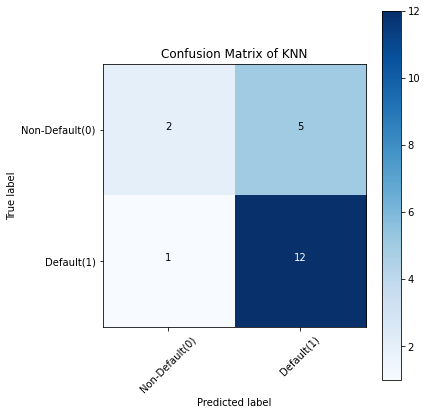

In [72]:
import itertools

def plot_confusion_matrix(cm, classes, title, normalize = False, cmap = plt.cm.Blues):
    title = 'Confusion Matrix of {}'.format(title)
    if normalize:
        cm = cm.astype(float) / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment = 'center',
                 color = 'white' if cm[i, j] > thresh else 'black')

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

knn_matrix = confusion_matrix(y_test, knn_yhat, labels = [0, 1]) # K-Nearest Neighbors

# Plot the confusion matrix
plt.rcParams['figure.figsize'] = (6, 6)


# 2. K-Nearest Neighbors

knn_cm_plot = plot_confusion_matrix(knn_matrix, 
                                classes = ['Non-Default(0)','Default(1)'], 
                                normalize = False, title = 'KNN')
plt.savefig('knn_cm_plot.png')
plt.show()

Source: https://scikit-learn.org/0.18/auto_examples/model_selection/plot_confusion_matrix.html

In [73]:
#predicting the Y label for our subscribers.
sub_pred = df_sub1_pred.values
prediction = knn.predict(sub_pred)

In [74]:
df_sub1['active_prediction'] = prediction.astype(int)
df_sub1

,email_address,industry,relationship_length,site_visits,avg_activity,activity_score,active_prediction
2,KTCGW@homeandgardenXYT.com,home and garden,30,225,8,19.0,1
3,YOQUFSG.YOQUFSG@EVTlandscapearchitect.biz,landscap,4,80,20,12.0,1
4,SOSNEJAL.SOSNEJAL@DXKDhg.net,hg,4,20,5,4.5,1
5,GGYDNEE3@homeandgardenBAHG.co,home and garden,12,48,4,8.0,0
6,AWM.AWM@AZVsupply.net,supply,30,993,33,31.5,1
...,...,...,...,...,...,...,...
674,HSIEGEET.HSIEGEET@IHBhg.co,hg,2,13,6,4.0,1
675,UHOJRMQQ.UHOJRMQQ@HRKMgrower.biz,grower,1,11,11,6.0,1
676,NOSKIDHL2@growerXOZ.co,grower,11,154,14,12.5,1
677,outdoorLMAJVIIP@yahoo.com,outdoor,30,303,10,20.0,1


In [75]:
# the model is predicting 1 label for 466 subscribers and 0 label for 142 subscribers.
df_sub1['active_prediction'].value_counts()

1    466
0    142
Name: active_prediction, dtype: int64

In [76]:
small_business_pred = pd.merge(df_sub1, small_business, on='email_address', how='inner')
small_business_pred['active_prediction'].value_counts()

1    60
0    16
Name: active_prediction, dtype: int64

In [77]:
medium_business_pred = pd.merge(df_sub1, medium_business, on='email_address', how='inner')
medium_business_pred['active_prediction'].value_counts()

1    149
0     44
Name: active_prediction, dtype: int64

In [78]:
large_business_pred = pd.merge(df_sub1, large_business, on='email_address', how='inner')
large_business_pred['active_prediction'].value_counts()

1    259
0     82
Name: active_prediction, dtype: int64

<AxesSubplot:xlabel='business', ylabel='Number of subscribers'>

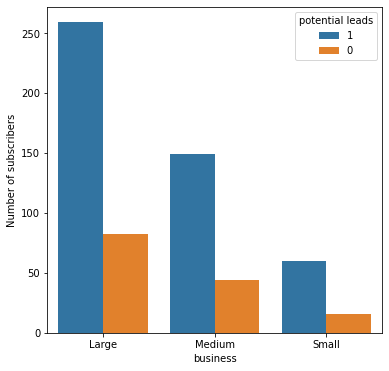

In [79]:
DF1 = pd.DataFrame({'business': ['Large', 'Medium', 'Small'], 'Number of subscribers': [259, 149, 60]})
DF2 = pd.DataFrame({'business': ['Large', 'Medium', 'Small'], 'Number of subscribers': [82, 44, 16]})

DF = pd.concat([DF1, DF2])
DF['potential leads'] = ['1','1','1','0','0','0']

sns.barplot(data = DF, x='business', y='Number of subscribers', hue='potential leads')

The above chart shows large, medium and small business with number of sunscribers in each category and if they are potential leads(1- yes, 0-no)

# Q1. Whether the vendor offering is worth discussing with your boss<a id="F"></a> 

Yes, the vendor offering is worth discussing with my boss. 

# Q2. Why or why not?<a id="F"></a> 

I did the following tasks to identify if the vendor offering is worth discussing:
### Tasks 
1. [Data Cleaning](#A)
    - check for nulls
        - there are 103 null values in industry column.
        - replaced null values in industry by industry_name if industry_name in email address.
        - reduced the number of null values to 23.
        - replaced the 23 null values with unknown industry.
    - merged similar/duplicate industry groups
        - reduced the number of industry groups from 20 to 14 by merging similar/ duplicate industry.
2. [Feature Engineering](#B) 
    - avg activity(per year) = no of times total_site_visits / relationship_length(years) will give us an idea of how active they have been on an yearly basis. (site_visits/ (relationship_length)). This was particularly chosen because some subscribers may be new to the magazine and so I wanted to see the activity for all the subscribers on the same scale.

    - activity_score: I needed a single activity score for my analysis so I decided to give 50% weightage to relationship_length and 50% weightage to avg activity (per year). Note: An assumption has been made that both metrics have equal weight, if either of these have more value then the weightage can be changed

        - activity_score = 0.5 x site_visits + 0.5 x avg_activity
        - high score means good consistent relation with the magazine
        - the activity score ranges from 0.5 - 445 with a median of 14.
3. [High level analysis of the subscriber data to categorize them as individual casual sellers and large/small businesses on the basis of email id, industry](#C.1)
  - The assumption is that the individual/ casual sellers are the ones who have not purchased a domain name.
  - Out of these casual sellers we still want to consider the ones which have industry name in there email ids. Since these can be businesses who have not purchased a domain name but are still relevant.
  - So we got 71 subscribers from the list which are casual sellers and would not add much revenue if pursued as a sales lead. We removed them from the dataframe.
  - Filtered 608/ 679 subscribers which could be qualified leads.
    
4. [Categorize data from previous filter into small, medium and large](#C.2)

  - small businesses on channel partners (in particular, Shopify, Magento, and BigCommerce):  1𝑘− 5k
      - Filtered 74 subscribers in small business category with channel partners Shopify, Magento, BigCommerce.
      - We can see that subscribers with an activity score in the range of 2.5-80.5, and a median of 14 are in the small category.
  
  - medium businesses with online or invoice sales:  10𝑘− 40k
      - Medium business can be considered as those who have not purchased a domain name but have industry names in the email id.
      - identified 193 subscribers who fall in the medium business category.
      - medium businesses have a slightly higher activity score than small businesses. Their activity falls in the range of 0.5- 445 with a median value of 22
  - large independent online sellers who do not offer:  70𝑘− 200k
      - businesses which have a website (identified based on a business domain name in their email id) can be considered as large businesses
      - The activity score for large business is in the range 0.5- 249 with a median of 9. This indicates lesser activities as compared to medium businesses. 
      
5. [Check if subscribers are current customers](#D)
    - Merge subscriber and customer dataframes to find out the subscribers who have converted into customers
    - Created a new df sub_as_cust which consists subscribers which are customers.
    - found 97/594 filtered subscribers to the magazine who converted into customers.
6. check all the entries from sub_as_cust who were active in the last one year
    - found 60/97 customers who were actively sending /receiving last year.
7. Find small/medium/large business customers as defined by categories in 4 above.
    - Found 7 small, 71 medium and 19 large business customers.
    - 4/7 small business customers, ~57% are active in the past year.
    - 47/71 medium business customers, ~66% were active in the past year.
    - 9/19 i.e. ~47% large business customers were active in the past year.
8. [Modelling](#E)
    - Created a df df2 as a copy of sub_as_cust(subscribers who are customers) df which has 97 rows.
    - Created a boolean label 'Y' using active send and active receive for prediction using supervised learning.
        - If active send/ active receive is 1: Y = 1
        - Else Y = 0
        - There are 60 positive labels and 37 negative labels in the df df2.
    - One hot encoding: to convert categorical data- industry into numeric values to be able to use in our model.
    - Feature Scaling using standard scaler to scale the relationship_length and site_visits column in both training df X1 and prediction dataframe.
    - Data Split
        - defined independent(X) and dependent(Y) variables.
        - Data is split into training and testing using train_test split.
    - Model
        - KNN is used for classification as active or not active.
        - the value of n=5, which means the decision of the target variable (active or not active) would depend on 5 nearest neighbors.
        - Got a accuracy of 70% and a f1 score of 80%.
        - From the confusion matrix it can be seen that the model has a good recall value that means it is able to predict 1 as 1 confidently.

### Analysis:
- Using active send and active receive to create a label for prediction using supervised learning is based on the assumption that if the prediction is 1 which is calculated by finding similar subscribers on the basis of industry, relationship_length and site_visits, it is highly likely that these subscribers can be potential customers.

- After the above tasks it can be established with a accuracy of 70% and a F1 score of 80% that 466/608 subscribers could be leads, out of which 60 are small business, 149 medium business and 259 large business users.

- It is also seen that medium business customers are most active both for the magazine and as customers and are likely to generate more business as compared to small and large businesses. 

- Since 76.6% of the subscribers are active leads - it is safe to say that the vendor offering is worth discussing with the boss.